# Setup



```
# Libraries
```



In [0]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from keras import applications
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback



```
# Set variables
```



In [0]:
img_width, img_height = 256, 256
train_data_dir = '/content/drive/My Drive/Colab Notebooks/one-piece-data/train'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/one-piece-data/test'
nb_train_samples = 286
nb_validation_samples = 30
batch_size = 8
epochs = 50

```
# Mount Google Drive for training data
```

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Model



```
# Load pretrained VGG19 ImageNet model
```



In [0]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))



```
# Freeze the first 5 layers we don't want to train
```



In [0]:
for layer in model.layers[:5]:
    layer.trainable = False



```
# Add layers to model and compile
```



In [0]:
# Add Layers
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(3, activation="softmax")(x)

# Creating the final model
model_final = Model(input = model.input, output = predictions)

# Compile the model
model_final.compile(loss = "categorical_crossentropy",
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9),
                    metrics=["accuracy"])

# Training



```
# Initialize train and test generators w/data augumentation
```



In [20]:
train_data = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_data = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

train_generator = train_data.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_data.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 286 images belonging to 3 classes.
Found 30 images belonging to 3 classes.




```
# Set training callbacks for saving checkpoints, early stopping, and TensorBoard
```



In [21]:
# Save the model according to the conditions
checkpoint = ModelCheckpoint("anime-classifier.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto', period=1)

early = EarlyStopping(monitor='val_acc',
                      min_delta=0,
                      patience=10,
                      verbose=1,
                      mode='auto')

tensorboard_callback=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://cd9be6d9.ngrok.io




```
# Train the model
```



In [22]:
model_final.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples // batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples // batch_size,
callbacks = [checkpoint, early, TensorBoardColabCallback(tensorboard_callback)])

Epoch 1/50
286/286 [==============================] - 27s 93ms/step - loss: 1.2959 - acc: 0.2902 - val_loss: 1.0988 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to anime-classifier.h5
Epoch 2/50
286/286 [==============================] - 25s 89ms/step - loss: 1.1000 - acc: 0.3427 - val_loss: 1.0813 - val_acc: 0.3600

Epoch 00002: val_acc improved from 0.33333 to 0.36000, saving model to anime-classifier.h5
Epoch 3/50
286/286 [==============================] - 26s 89ms/step - loss: 1.0904 - acc: 0.3566 - val_loss: 1.0228 - val_acc: 0.4644

Epoch 00003: val_acc improved from 0.36000 to 0.46444, saving model to anime-classifier.h5
Epoch 4/50
286/286 [==============================] - 26s 89ms/step - loss: 1.0808 - acc: 0.4056 - val_loss: 1.0949 - val_acc: 0.3556

Epoch 00004: val_acc did not improve from 0.46444
Epoch 5/50
286/286 [==============================] - 26s 89ms/step - loss: 1.1012 - acc: 0.4021 - val_loss: 1.0566 - val_acc: 0.4500

Epoch

# Test

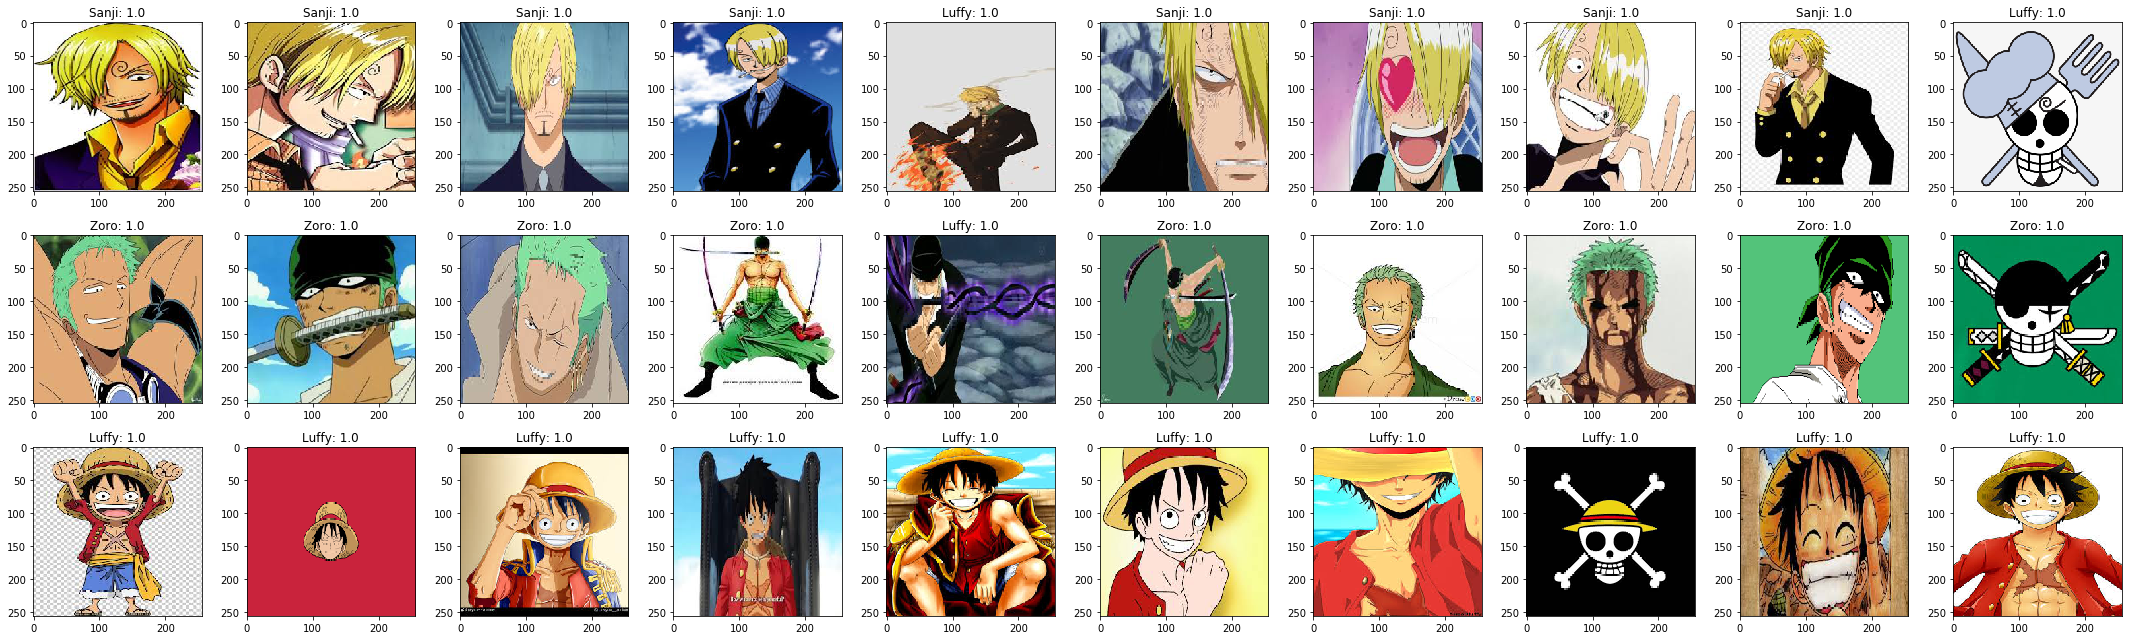

In [76]:
labels = ['Luffy', 'Sanji', 'Zoro']
i = 0

plt.figure(figsize=(30,9))

for filename in glob.glob('/content/drive/My Drive/Colab Notebooks/one-piece-data/test/**/*.*', recursive=True):
    img = load_img(filename, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    out = model_final.predict(img_array)
    out_label = labels[np.argmax(out)]
    out_prob = round(np.max(out),3)
    
    plt.subplot(3,10,1 + i)
    plt.imshow(img)
    plt.title(out_label + ': ' + str(out_prob))
    plt.tight_layout()

    i += 1    

plt.savefig('output.png')
plt.show()
